# Example 3.1
The Graphical and numerical solution to the $\beta$ eigenvalue equation.

We have a planar dielectric structure shown below. We want to determine the allowed values of $\beta$, assuming the wavelength of the light exciting the waveguide is 1 $\mu\text{m}$.

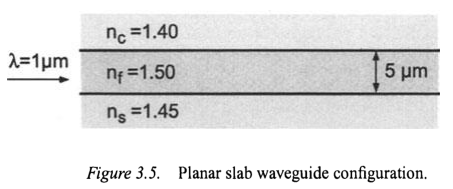

### Solution

In this case, we need to solve the eigenvalue equation
$$\tan(h\kappa_f) = \frac{\gamma_c + \gamma_s}{\kappa_f\bigg[1 - \frac{\gamma_c\gamma_s}{\kappa_f^2}\bigg]}$$

Here, we know that $\beta$ is the z-component of the $k_0n_f$, hence $0< \beta < k_0n_f$. Also, when it says $\lambda$ is used to excite the waveguide, it is used to calculate the $k_0$. We took a different approach from the book, the book parameterized the value of $\kappa_f$ instead of $\beta$. It somehow seems easier to solve (?)

In [102]:
# Import libraries and define variables
import numpy as np
import photonics_tools.basic_tools as tools
import photonics_tools.slab_1d_tools as slab
import matplotlib.pyplot as plt
from scipy.optimize import minimize, fsolve

# Define variables
lamb0 = 1e-6 # meter
nc = 1.4
nf = 1.5
ns = 1.45
d = 5e-6 # meter of core thickness

k0 = tools.lamb2wavevector(lamb_vac=lamb0)

In [96]:
# Now we can start solving things
beta = np.linspace(k0*ns, k0*nf, 1000) # beta ranges between 0 and k0*nf. But when it is less than k0*ns, it's not confining anymore, but let's try anyway
gammac = slab.attenuation_coefficient(k0, nc, beta)
gammas = slab.attenuation_coefficient(k0, ns, beta)
kappaf = slab.transverse_wavevector(k0, nf, beta)

In [97]:
y1 = np.tan(d*kappaf)
y2 = (gammac + gammas)/(kappaf*(1-((gammac*gammas)/(kappaf**2))))

C:\Users\cahya\AppData\Local\Temp\ipykernel_5312\1940723714.py:2: RuntimeWarning: divide by zero encountered in divide
  y2 = (gammac + gammas)/(kappaf*(1-((gammac*gammas)/(kappaf**2))))
C:\Users\cahya\AppData\Local\Temp\ipykernel_5312\1940723714.py:2: RuntimeWarning: invalid value encountered in multiply
  y2 = (gammac + gammas)/(kappaf*(1-((gammac*gammas)/(kappaf**2))))


In [111]:
# We need to find the solution via rootfinding

def functional(beta):
    kapf = slab.transverse_wavevector(k0, nf, beta)
    gamc = slab.attenuation_coefficient(k0, nc, beta)
    gams = slab.attenuation_coefficient(k0, ns, beta)
    return np.abs((np.tan(d*kapf)) - ((gamc + gams)/(kapf*(1-((gamc*gams)/(kapf**2))))))

#sol = minimize(functional, 9.424777e6, bounds=[(9.35e6, k0*nf-1e-6)])
sol = fsolve(functional, [9.175e6, 9.25e6, 9.35e6, 9.4e6]) # The initial guess is acquired from the graph
print(sol) # This result is the same as the one we got in the book.

[9175214.99416081 9281844.87217623 9360796.84377473 9408732.72761188]


[]

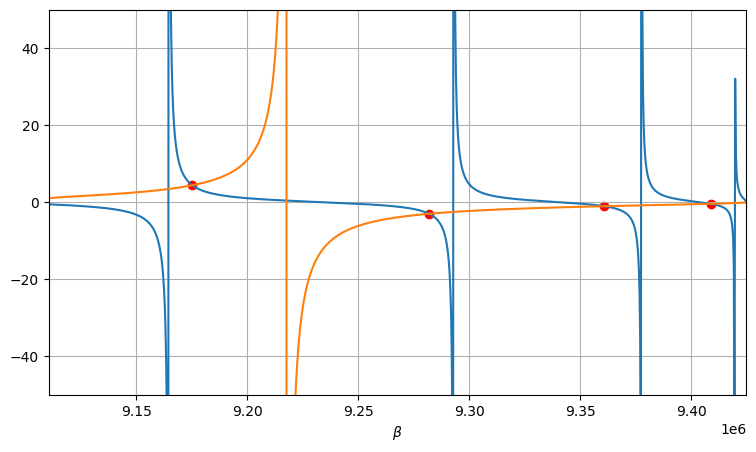

In [113]:
fig, ax = plt.subplots(1,1,figsize = (9,5))
ax.plot(beta, y1)
ax.plot(beta, y2)
for s in sol:
    ax.scatter(s, np.tan(d*slab.transverse_wavevector(k0, nf, s)), color = 'red')
ax.set_ylim([-50,50])
ax.set_xlim([k0*ns, k0*nf])
ax.grid(True)
ax.set_xlabel("$\\beta$")
plt.plot()